<a href="https://colab.research.google.com/github/Aestivation/assignment7_mnist_mlp/blob/main/code/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q keras-tuner

import numpy as np
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


/tmp/ipython-input-2561140543.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# مقیاس‌دهی تصاویر (0-1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [ ]:
def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))

    # تعداد لایه‌های مخفی داینامیک
    for i in range(hp.Int('num_hidden_layers', min_value=2, max_value=5)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
            activation='relu'
        ))

    # لایه خروجی
    model.add(keras.layers.Dense(10, activation='softmax'))

    # کامپایل مدل با یادگیری داینامیک
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,  # برای تست سریع، بعداً می‌توانید افزایش دهید
    executions_per_trial=1,
    directory='my_dir',
    project_name='mnist_mlp_tuning'
)

# شروع جستجو
tuner.search(x_train, y_train, epochs=10, validation_split=0.1)


Trial 15 Complete [00h 01m 59s]
val_accuracy: 0.9741666913032532

Best val_accuracy So Far: 0.9801666736602783
Total elapsed time: 00h 33m 39s


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best number of hidden layers:", best_hps.get('num_hidden_layers'))
for i in range(best_hps.get('num_hidden_layers')):
    print(f"Units in layer {i+1}:", best_hps.get(f'units_{i}'))
print("Best learning rate:", best_hps.get('learning_rate'))

# ساخت مدل نهایی با بهترین Hyperparameters
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    x_train, y_train,
    epochs=25,
    validation_split=0.1,
    batch_size=64
)


Best number of hidden layers: 5
Units in layer 1: 512
Units in layer 2: 192
Units in layer 3: 128
Units in layer 4: 192
Units in layer 5: 64
Best learning rate: 0.0009116023591102821
Epoch 1/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8705 - loss: 0.4327 - val_accuracy: 0.9680 - val_loss: 0.1136
Epoch 2/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9679 - loss: 0.1042 - val_accuracy: 0.9732 - val_loss: 0.0877
Epoch 3/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9788 - loss: 0.0702 - val_accuracy: 0.9750 - val_loss: 0.0935
Epoch 4/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9832 - loss: 0.0558 - val_accuracy: 0.9688 - val_loss: 0.1137
Epoch 5/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9859 - loss: 0.0455 - val_accuracy: 0.9748 - val_loss: 0.0864
Epoch 6/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9887 - loss: 0.0373 - val_accuracy: 0.9718 - val_loss: 0.1099
Epoch 7/25
844/844 ━━━━━━━━━━━━━━━━━━

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9813 - loss: 0.1364
Test Accuracy: 98.33%


In [ ]:
# saving model for Github
model.save('best_mnist_mlp.h5')


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("num_hidden_layers:", best_hps.get('num_hidden_layers'))
for i in range(best_hps.get('num_hidden_layers')):
    print(f"units_{i}:", best_hps.get(f'units_{i}'))
print("learning_rate:", best_hps.get('learning_rate'))



num_hidden_layers: 5
units_0: 512
units_1: 192
units_2: 128
units_3: 192
units_4: 64
learning_rate: 0.0009116023591102821


In [ ]:
tuner.results_summary()   # summary of the best results
trials = tuner.oracle.get_best_trials(num_trials=10)
for t in trials:
    print(t.hyperparameters.values, t.score)


Results summary
Results in my_dir/mnist_mlp_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 11 summary
Hyperparameters:
num_hidden_layers: 5
units_0: 512
units_1: 192
learning_rate: 0.0009116023591102821
units_2: 128
units_3: 192
units_4: 64
Score: 0.9801666736602783

Trial 07 summary
Hyperparameters:
num_hidden_layers: 4
units_0: 448
units_1: 64
learning_rate: 0.0004786671903284127
units_2: 128
units_3: 128
units_4: 256
Score: 0.9788333177566528

Trial 08 summary
Hyperparameters:
num_hidden_layers: 3
units_0: 256
units_1: 320
learning_rate: 0.0015012820193408534
units_2: 448
units_3: 320
units_4: 320
Score: 0.9785000085830688

Trial 09 summary
Hyperparameters:
num_hidden_layers: 2
units_0: 256
units_1: 256
learning_rate: 0.00012659365133310544
units_2: 448
units_3: 320
units_4: 128
Score: 0.9785000085830688

Trial 10 summary
Hyperparameters:
num_hidden_layers: 5
units_0: 384
units_1: 128
learning_rate: 0.004113819084881901
units_2: 384
units_3: 64


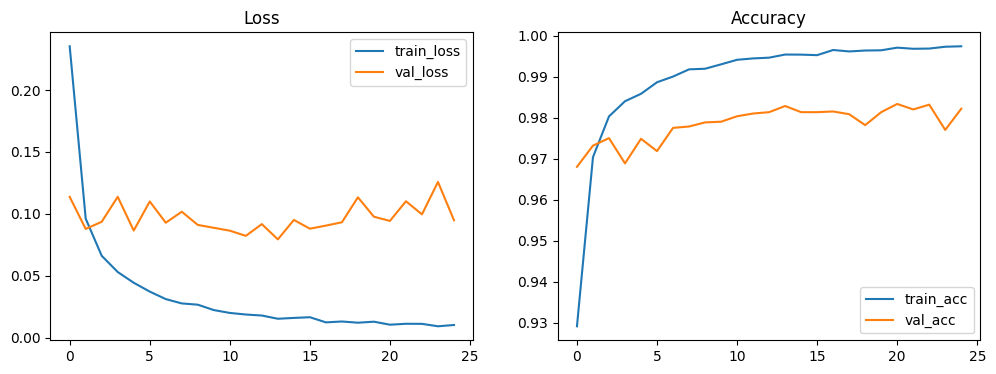

In [ ]:
import matplotlib.pyplot as plt

# history از model.fit نهایی هست
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.99      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



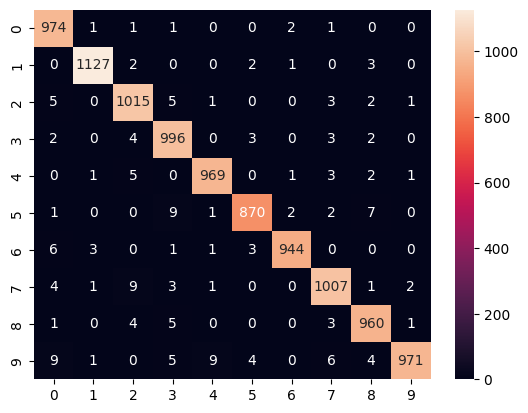

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_pred))


In [ ]:
import time
t0 = time.time()
history = model.fit(x_train, y_train, epochs=25, validation_split=0.1, batch_size=64)
train_time = time.time() - t0
print(f"Training time (s): {train_time:.1f}")


Epoch 1/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.9817 - val_loss: 0.1120
Epoch 2/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9968 - loss: 0.0127 - val_accuracy: 0.9828 - val_loss: 0.1029
Epoch 3/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9977 - loss: 0.0085 - val_accuracy: 0.9827 - val_loss: 0.1025
Epoch 4/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9973 - loss: 0.0113 - val_accuracy: 0.9805 - val_loss: 0.1279
Epoch 5/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9978 - loss: 0.0093 - val_accuracy: 0.9838 - val_loss: 0.1072
Epoch 6/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9984 - loss: 0.0068 - val_accuracy: 0.9820 - val_loss: 0.1261
Epoch 7/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9973 - loss: 0.0119 - val_accuracy: 0.9825 - val_loss: 0.1233
Epoch 8/25
844/844 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9971 - loss: 0.0138 - 